In [80]:
import numpy as np
import pandas as pd
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# read data

In [81]:
data = pd.read_excel(r'list-FUC.xlsx')
inputData = np.array(data.iloc[:,2:])
outputData = np.array(data.iloc[:,1])

# hyperparameter optimization

In [82]:
test_size = 0.2
def generateRfrParamGrid(low1,high1,num1,low2,high2,num2):      # 
    param_grid = {
        'n_estimators':np.arange(int(low1),int(high1),int(num1)),
        'max_depth':np.arange(int(low2),int(high2),int(num2))
    }
    return param_grid
param = generateRfrParamGrid(300,500,10,3,7,1)
rfr = RandomForestRegressor()
search = GridSearchCV(rfr,param_grid=param,n_jobs=-1,cv=2)
for i in range(10):
        X_train,X_test,y_train,y_test = train_test_split(inputData,outputData,test_size=test_size,random_state=None)    # Randomly split data                                                                                                                  # 该方法对dataframe也适用
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train=min_max_scaler.fit_transform(X_train)
        X_test=min_max_scaler.fit_transform(X_test)
        y_train=min_max_scaler.fit_transform(y_train.reshape(-1,1)).ravel()   # converts it to a column
        y_test=min_max_scaler.fit_transform(y_test.reshape(-1,1)).ravel()    # converts it to a column       
        search.fit(X_train,y_train)      # fitting
        regr = search.best_estimator_        
        score = regr.score(X_test,y_test)  # score
        if i == 0:
            max_score = score           # at run 0, record R2 and the model at this point
        if i>0:
            if score>max_score:
                choose_regr = regr   

In [83]:
choose_regr

RandomForestRegressor(max_depth=6, n_estimators=310)

In [84]:
best_max_depth = choose_regr.max_depth
best_n_estimators = choose_regr.n_estimators

In [123]:
from sklearn.model_selection import cross_val_score, KFold

RFR_ = RFR(n_estimators=best_n_estimators ,max_depth=best_max_depth)
kf = KFold(n_splits=5)
score = []
for i in list(range(1, 20, 1)) + list(range(20, 210, 10)):
    cv_scores = []
    for train_index, test_index in kf.split(inputData):
        X_train, X_test = inputData[train_index], inputData[test_index]
        y_train, y_test = outputData[train_index], outputData[test_index]
        
        selector = RFE(RFR_, n_features_to_select=i, step=50)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        RFR_.fit(X_train_selected, y_train)
        cv_scores.append(RFR_.score(X_test_selected, y_test))
        
    score.append(np.mean(cv_scores))
 

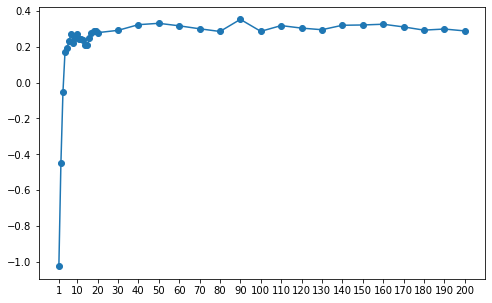

In [124]:
plt.figure(figsize=[8,5])
plt.plot(list(range(1,20,1))+list(range(20,210,10)),score,'o-')
plt.xticks([1]+list(range(10,210,10)))
plt.savefig("list-RFE-processed-feature-fixed-10.png")
plt.show()

In [125]:
B = pd.DataFrame(score)
B.to_csv("list-RFE-R2-fixed-10.csv",index=False,sep=',')

In [126]:
X_wrapper = RFE(RFR_,n_features_to_select=20,step=50).fit_transform(inputData,outputData)

In [127]:
X_wrapper

array([[-7.26900000e-01,  6.52100000e+02, -1.24140000e+00, ...,
         1.36020000e+03,  3.00338333e+03,  2.11108571e+03],
       [ 4.90000000e-01,  6.52900000e+02, -1.22367143e+00, ...,
         1.88270000e+03,  2.86576667e+03,  2.19384286e+03],
       [-4.78100000e-01,  6.58500000e+02, -1.03505714e+00, ...,
         1.46122857e+03,  3.10038333e+03,  2.21437143e+03],
       ...,
       [-9.88700000e-01,  6.00000000e+02, -1.05640000e+00, ...,
         8.94537143e+02,  2.21038333e+03,  1.59508571e+03],
       [-5.27900000e-01,  6.40100000e+02, -1.19870000e+00, ...,
         4.84394286e+02,  2.53412000e+03,  1.52992000e+03],
       [-5.27900000e-01,  6.40100000e+02, -1.15270000e+00, ...,
         9.41537143e+02,  2.69271667e+03,  1.80180000e+03]])

In [128]:
X_wrapper.shape

(150, 20)

In [129]:
A = pd.DataFrame(X_wrapper)

In [130]:
A.to_csv("list-RFE-fixed-10.csv",index=False,sep=',')